# Improving ProteinMPNN PD-L1 Binding Dynamics Using Iterative Mutagenesis

In [1]:
# Setup
%%time
import os

# Install necessary packages if they aren't already installed
if not os.path.isdir("params"):
    os.system("pip -q install pyppeteer nest_asyncio")
    os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git")
    os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
    os.system("mkdir params")
    os.system("apt-get install aria2 -qq")
    os.system("aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar")
    os.system("tar -xf alphafold_params_2022-12-06.tar -C params")

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import necessary modules
from colabdesign import mk_afdesign_model, clear_mem
from colabdesign.mpnn import mk_mpnn_model
from colabdesign.shared.protein import alphabet_list as chain_list
from IPython.display import HTML
from google.colab import files
import numpy as np
from transformers import AutoTokenizer, EsmForMaskedLM
import torch
import matplotlib.pyplot as plt
import jax.numpy as jnp
from sklearn.preprocessing import LabelEncoder
import requests, time
import asyncio
import nest_asyncio
from pyppeteer import launch
import base64

# Apply nest_asyncio to enable nested event loops
nest_asyncio.apply()

# TM-score calculation helper function
def tmscore(x, y):
    output = os.popen(f'./TMscore {x} {y}')
    parse_float = lambda x: float(x.split("=")[1].split()[0])
    o = {}
    for line in output:
        line = line.rstrip()
        if line.startswith("RMSD"): o["rms"] = parse_float(line)
        if line.startswith("TM-score"): o["tms"] = parse_float(line)
        if line.startswith("GDT-TS-score"): o["gdt"] = parse_float(line)
    return o

# Function to fetch and decode PDB content from a URL
async def fetch_blob_content(page, blob_url):
    blob_to_base64 = """
    async (blobUrl) => {
        const blob = await fetch(blobUrl).then(r => r.blob());
        return new Promise((resolve) => {
            const reader = new FileReader();
            reader.onloadend = () => resolve(reader.result);
            reader.readAsDataURL(blob);
        });
    }
    """
    base64_data = await page.evaluate(blob_to_base64, blob_url)
    _, encoded = base64_data.split(',', 1)
    return base64.b64decode(encoded)

async def extract_pdb_file_download_link_and_content(url):
    browser = await launch(headless=True, args=['--no-sandbox', '--disable-setuid-sandbox'])
    page = await browser.newPage()
    await page.goto(url, {'waitUntil': 'networkidle0'})
    elements = await page.querySelectorAll('a.btn.bg-purple')
    for element in elements:
        href = await page.evaluate('(element) => element.getAttribute("href")', element)
        if 'blob:https://esmatlas.com/' in href:
            content = await fetch_blob_content(page, href)
            await browser.close()
            return href, content
    await browser.close()
    return "No PDB file link found.", None

# Function to call esmfold API and fetch PDB string
def esmfold_api(sequence):
    #Input PDB PATH
    url = !wget file://C:/Users/iaind/OneDrive/UVM/DeepBME/Final\ Project/rcsb_pdb_5JDR.fasta
    result = asyncio.get_event_loop().run_until_complete(extract_pdb_file_download_link_and_content(url))
    if result[1]:
        pdb_str = result[1].decode('utf-8')
        return pdb_str
    else:
        return "Failed to retrieve PDB content."

# Importing JAX and AlphaFold residue constants
import jax
from colabdesign.af.alphafold.common import residue_constants


CPU times: user 12.9 s, sys: 1.3 s, total: 14.2 s
Wall time: 1min 55s


In [2]:
#@title # hallucination
#@markdown For a given length, generate/hallucinate a protein sequence that AlphaFold thinks folds into a well structured protein (high plddt, low pae, many contacts).
LENGTH = 150 #@param {type:"integer"}
COPIES = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw"}
MODE = "manuscript" #@param ["original", "manuscript"]
use_rg_loss = True #@param {type:"boolean"}

#@markdown ProteinMPNN Settings
use_mpnn_loss = True #@param {type:"boolean"}
use_solubleMPNN = True #@param {type:"boolean"}
#@markdown

def add_rg_loss(self, weight=0.1):
  '''add radius of gyration loss'''
  def loss_fn(inputs, outputs):
    xyz = outputs["structure_module"]
    ca = xyz["final_atom_positions"][:,residue_constants.atom_order["CA"]]
    if self.protocol == "binder":
      ca = ca[-self._binder_len:]
    if MODE == "manuscript":
      ca = ca[::5]
    rg = jnp.sqrt(jnp.square(ca - ca.mean(0)).sum(-1).mean() + 1e-8)
    if MODE == "original":
      rg_th = 2.38 * ca.shape[0] ** 0.365
      rg = jax.nn.elu(rg - rg_th)
    return {"rg":rg}
  self._callbacks["model"]["loss"].append(loss_fn)
  self.opt["weights"]["rg"] = weight

def add_mpnn_loss(self, mpnn=0.1, mpnn_seq=0.0):
  '''
  add mpnn loss
  mpnn = maximize confidence of proteinmpnn
  mpnn_seq = push designed sequence to match proteinmpnn logits
  '''

  self._mpnn = mk_mpnn_model(weights = "soluble" if use_solubleMPNN else "original")
  def loss_fn(inputs, outputs, aux, key):

    # get structure
    atom_idx = tuple(residue_constants.atom_order[k] for k in ["N","CA","C","O"])
    I = {"S":           inputs["aatype"],
         "residue_idx": inputs["residue_index"],
         "chain_idx":   inputs["asym_id"],
         "X":           outputs["structure_module"]["final_atom_positions"][:,atom_idx],
         "mask":        outputs["structure_module"]["final_atom_mask"][:,1],
         "lengths":     self._lengths,
         "key":         key}

    if "offset" in inputs:
      I["offset"] = inputs["offset"]

    # set autoregressive mask
    L = sum(self._lengths)
    if self.protocol == "binder":
      I["ar_mask"] = 1 - np.eye(L)
      I["ar_mask"][-self._len:,-self._len:] = 0
    else:
      I["ar_mask"] = np.zeros((L,L))

    # get logits
    logits = self._mpnn._score(**I)["logits"][:,:20]
    if self.protocol == "binder":
      logits = logits[-self._len:]
    else:
      logits = logits[:self._len]
    aux["mpnn_logits"] = logits

    # compute loss
    log_q = jax.nn.log_softmax(logits)
    p = inputs["seq"]["hard"]
    q = jax.nn.softmax(logits)
    losses = {}
    losses["mpnn"] = -log_q.max(-1).mean()
    losses["mpnn_seq"] = -(p * jax.lax.stop_gradient(log_q)).sum(-1).mean()
    return losses

  self._callbacks["model"]["loss"].append(loss_fn)
  self.opt["weights"]["mpnn"] = mpnn
  self.opt["weights"]["mpnn_seq"] = mpnn_seq

clear_mem()
af_model = mk_afdesign_model(protocol="hallucination")
af_model.prep_inputs(length=LENGTH, copies=COPIES)

# add extra losses
if use_rg_loss:   add_rg_loss(af_model)
if use_mpnn_loss: add_mpnn_loss(af_model)

print("length",af_model._lengths)
print("weights",af_model.opt["weights"])

length [150]
weights {'con': 1.0, 'exp_res': 0.0, 'helix': 0.0, 'pae': 0.0, 'plddt': 0.0, 'seq_ent': 0.0, 'rg': 0.1, 'mpnn': 0.1, 'mpnn_seq': 0.0}


In [3]:
af_model.restart()
if MODE == "original":
  # pre-design with gumbel initialization and softmax activation
  af_model.set_weights(plddt=0.0, pae=0.0)
  af_model.set_seq(mode=["gumbel"])
  af_model.design_soft(50)
  af_model.set_seq(af_model.aux["seq"]["pseudo"])

if MODE == "manuscript":
  af_model.set_seq(mode=["gumbel","soft"])

af_model.set_weights(plddt=1.0, pae=1.0)
af_model.design_logits(40)
af_model.design_logits(10, save_best=True)

1 models [2] recycles 0 hard 0 soft 0 temp 1 loss 11.82 pae 0.80 con 6.44 plddt 0.54 ptm 0.13 mpnn 2.08 rg 39.12
2 models [2] recycles 0 hard 0 soft 0 temp 1 loss 8.18 pae 0.73 con 4.09 plddt 0.43 ptm 0.21 mpnn 1.89 rg 26.05
3 models [1] recycles 0 hard 0 soft 0 temp 1 loss 9.08 pae 0.70 con 4.48 plddt 0.51 ptm 0.24 mpnn 1.87 rg 32.22
4 models [0] recycles 0 hard 0 soft 0 temp 1 loss 9.08 pae 0.63 con 5.00 plddt 0.72 ptm 0.30 mpnn 1.88 rg 29.82
5 models [1] recycles 0 hard 0 soft 0 temp 1 loss 7.70 pae 0.53 con 4.05 plddt 0.67 ptm 0.36 mpnn 1.77 rg 26.13
6 models [1] recycles 0 hard 0 soft 0 temp 1 loss 6.23 pae 0.44 con 3.27 plddt 0.67 ptm 0.45 mpnn 1.64 rg 20.23
7 models [4] recycles 0 hard 0 soft 0 temp 1 loss 5.94 pae 0.42 con 3.21 plddt 0.68 ptm 0.48 mpnn 1.66 rg 18.26
8 models [0] recycles 0 hard 0 soft 0 temp 1 loss 5.72 pae 0.40 con 3.10 plddt 0.65 ptm 0.50 mpnn 1.52 rg 17.28
9 models [3] recycles 0 hard 0 soft 0 temp 1 loss 5.39 pae 0.35 con 2.85 plddt 0.71 ptm 0.57 mpnn 1.48 

In [4]:
af_model.save_pdb(f"{af_model.protocol}.pdb")
af_model.plot_pdb()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [5]:
HTML(af_model.animate())

In [6]:
af_model.get_seqs()

['SRWYRDGRGQRAFDHWLPPVVRHDEMYRDMNALGRAAQDQVWAIPDKGNSQNGHPLSPDELLRECMGLLPDIIDTLIGQFARHLRAGHFDRTMARIEGPTEKHRMDVRWSYWWLLDFQIHKVLYAGLDVMAPNRPQAIPYLLELLDQMIS']

In [7]:
#@markdown #Redesign with ProteinMPNN
num_seqs = 8 #@param ["8", "16", "32", "64"] {type:"raw"}
mpnn_sampling_temp = 0.1 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
rm_aa = "C" #@param {type:"string"}
use_solubleMPNN = False #@param {type:"boolean"}
#@markdown - `mpnn_sampling_temp` - control diversity of sampled sequences. (higher = more diverse).
#@markdown - `rm_aa='C'` - do not use [C]ysteines.
#@markdown - `use_solubleMPNN` - use weights trained only on soluble proteins. See [preprint](https://www.biorxiv.org/content/10.1101/2023.05.09.540044v2).
#@markdown

In [8]:
mpnn_model = mk_mpnn_model()
mpnn_model.prep_inputs(
    pdb_filename=f"{af_model.protocol}.pdb",
    chain=",".join(chain_list[:COPIES]),
    homooligmer=COPIES > 1,
    rm_aa=rm_aa,
    weights="soluble" if use_solubleMPNN else "original"
)

# Generate sequences and scores
out = mpnn_model.sample(
    num=num_seqs // 8,
    batch=8,
    temperature=mpnn_sampling_temp
)

# Find the sequence with the highest score
best_score = None
best_seq = None

for seq, score in zip(out["seq"], out["score"]):
    print(score, seq.split("/")[0])  # Print all scores and sequences
    if best_score is None or score > best_score:
        best_score = score
        best_seq = seq.split("/")[0]

# Store the best sequence in the `best` variable
best = {"sequence": best_seq, "score": best_score}

print("\nBest Sequence:")
print(f"Score: {best['score']}, Sequence: {best['sequence']}")


0.9670436371218192 MEEVRDGSAWAKFEATLPKEVLESEAYKELKALAKAAVAEVLAILERARGADGRPLTPEELFAETRALLPPLLARLLATYEAHMKAGEFEKTLSKIPNPTPEDEKLIKASFEAILQFAIDAVLAAAAEVMAPRAAEAEPFLAALRAAIEA
0.8677060244895708 AAAVRDGTAWAAFRATLPAEVLASPAFADLEAAARAAVAAVLAIAERARGADGVPLTPAELFAETRALLPPLLAALRALAAAHAAAGAFEATLAKIPDPTAADRKTIRAAFAALLAHAVDAVLAAAAEVMAPRAAEAAPFLAAQRAALAA
0.9615218514556421 AAHYRDGSAWEEFEATLPEEVLASEIYKTLKALAEEAVAEVLAILEEARGGDGVPLTPEELFERTRALLPGLLARLIATYNAHIEAGSFEKTLAKIPNPTAEDEEKIKKAFEDLLAFAIDAVLDAAAEVMAPLAERAAPYLAALRAEIAA
0.8943194407621853 MPYVVDGRAWADFDATLPAAVRASEAYAALRALSEAAVAAVLAILAEAEGADGVPLTPEELFARTRALLPGLLAALQAAYEAALAAGAFAKTLATIPNPTAADAKTVRAAFAALLAFGVDAVLAAAAYVMAPRAEEAAPYLAALRAALAA
0.8837046995666579 AEYWADGAAWADFRATLPAHVLASPLFAELEAAARAAVARVRAILEEARGGDGVPLSPEELFARTKALLPGLLAELRALYAAGLEAGAFEATLATIPNPTAADRRRIRAAFAATLAFAVDAVLDAAREVMAPRAAEAEPFLAAQRAALAA
0.9309835767125315 MEKVENGEAWAEFEATLPPEVLASPAYRELKALAEEKVAAILAILEEARGGDGRPLTPEELFARTRALLPGLLAELRATYEAHRAAGELERTLARIPDPTAADRARVEAAFEATLEFAVDAVIAAAAEVMA

#Automatically choses the best of the generated proteins sequences above

#Can manually enter a preffered sequence for "protein_sequence"


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

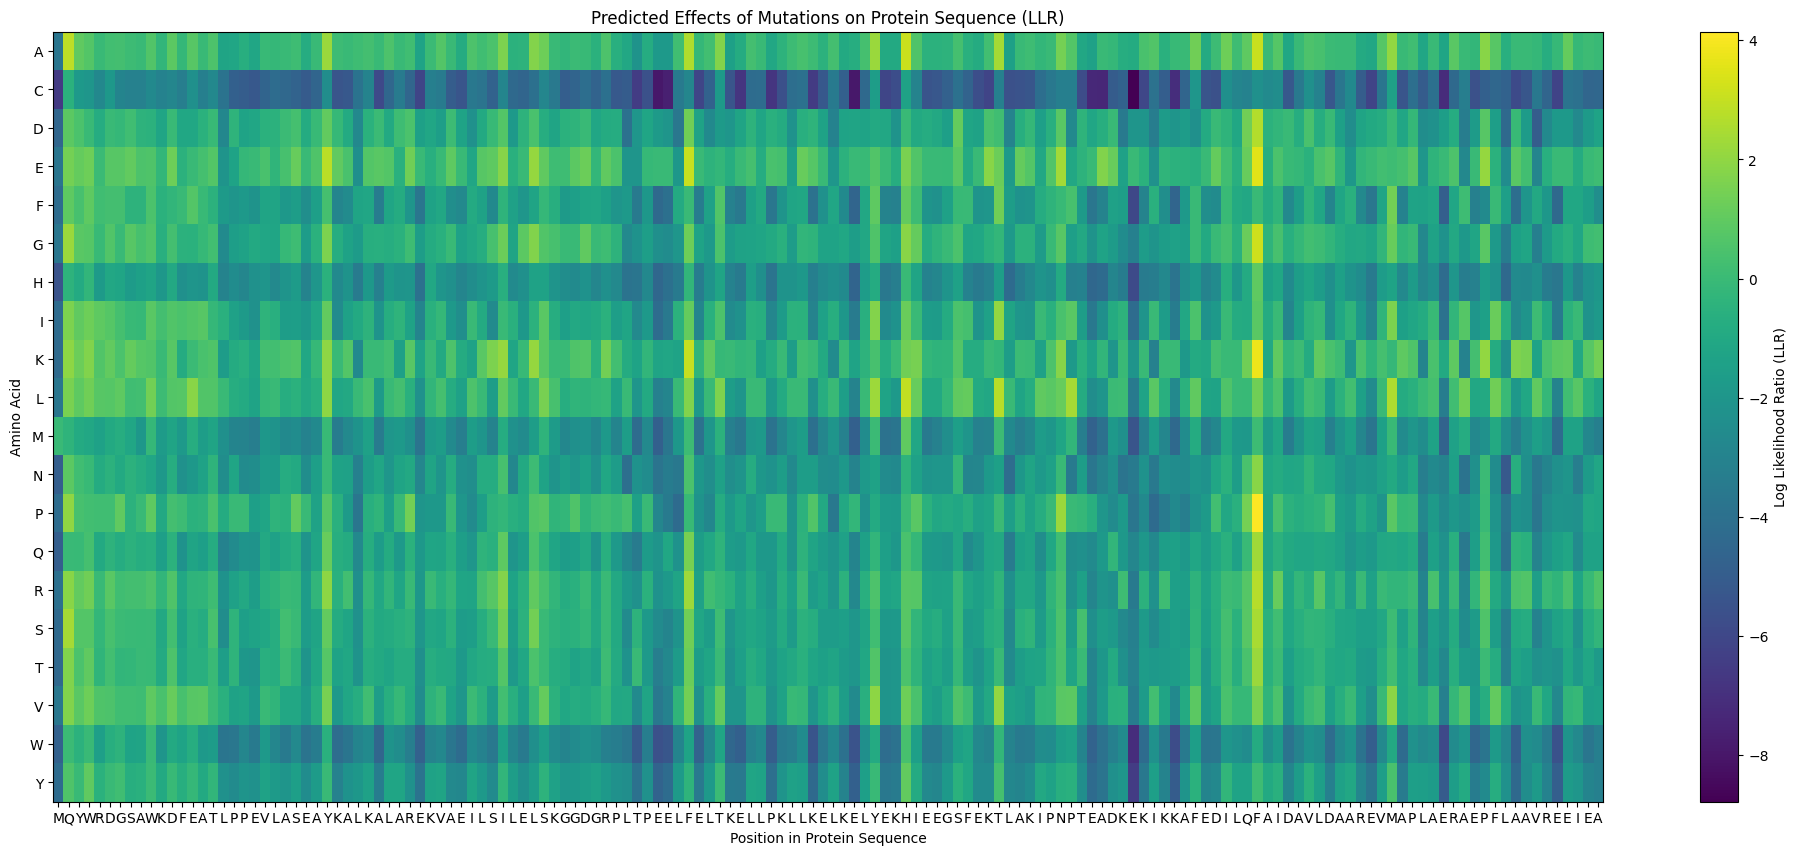

Average LLR score of the model: -1.29


In [9]:

from transformers import AutoTokenizer, EsmForMaskedLM
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load the model and tokenizer
model_name = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = EsmForMaskedLM.from_pretrained(model_name)

# Input protein sequence
protein_sequence = best['sequence']  # Replace 'best' with your specific variable containing the sequence
protein_sequence_initial = protein_sequence
# Tokenize the input sequence
input_ids = tokenizer.encode(protein_sequence, return_tensors="pt")
sequence_length = input_ids.shape[1] - 2  # Excluding the special tokens

# List of amino acids
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

# Initialize heatmap
heatmap = np.zeros((20, sequence_length))

# Calculate LLRs for each position and amino acid
for position in range(1, sequence_length + 1):
    # Mask the target position
    masked_input_ids = input_ids.clone()
    masked_input_ids[0, position] = tokenizer.mask_token_id

    # Get logits for the masked token
    with torch.no_grad():
        logits = model(masked_input_ids).logits

    # Calculate log probabilities
    probabilities = torch.nn.functional.softmax(logits[0, position], dim=0)
    log_probabilities = torch.log(probabilities)

    # Get the log probability of the wild-type residue
    wt_residue = input_ids[0, position].item()
    log_prob_wt = log_probabilities[wt_residue].item()

    # Calculate LLR for each variant
    for i, amino_acid in enumerate(amino_acids):
        log_prob_mt = log_probabilities[tokenizer.convert_tokens_to_ids(amino_acid)].item()
        heatmap[i, position - 1] = log_prob_mt - log_prob_wt

# Calculate the average LLR score
average_llr = np.mean(heatmap)
heatmap_initial = heatmap
# Visualize the heatmap
plt.figure(figsize=(25, 10))
plt.imshow(heatmap, cmap="viridis", aspect="auto") #, vmin=-10, vmax=10)
plt.xticks(range(sequence_length), list(protein_sequence))
plt.yticks(range(20), amino_acids)
plt.xlabel("Position in Protein Sequence")
plt.ylabel("Amino Acid")
plt.title("Predicted Effects of Mutations on Protein Sequence (LLR)")

# Add a color bar with fixed range
cbar = plt.colorbar(label="Log Likelihood Ratio (LLR)")
#cbar.set_ticks(np.arange(-10, 11, 5))  # Optional: Customize ticks

# Show the plot
plt.show()

# Print the average LLR score
print(f"Average LLR score of the model: {average_llr:.2f}")




In [10]:
# Flatten the heatmap and sort indices
flat_heatmap = heatmap.flatten()
sorted_indices = np.argsort(flat_heatmap)

# Get the 10 best and 10 worst mutations
best_indices = sorted_indices[-10:]
worst_indices = sorted_indices[:10]

# Convert flat indices back to amino acid and position
best_mutations = [(amino_acids[idx // sequence_length], idx % sequence_length + 1, flat_heatmap[idx]) for idx in best_indices]
worst_mutations = [(amino_acids[idx // sequence_length], idx % sequence_length + 1, flat_heatmap[idx]) for idx in worst_indices]

# Print results
print("10 Best Mutations:")
for aa, pos, score in best_mutations:
    print(f"Amino Acid: {aa}, Position: {pos}, LLR: {score:.4f}")

print("\n10 Worst Mutations:")
for aa, pos, score in worst_mutations:
    print(f"Amino Acid: {aa}, Position: {pos}, LLR: {score:.4f}")


10 Best Mutations:
Amino Acid: A, Position: 2, LLR: 2.8332
Amino Acid: L, Position: 83, LLR: 2.9457
Amino Acid: K, Position: 62, LLR: 2.9927
Amino Acid: A, Position: 117, LLR: 3.0374
Amino Acid: E, Position: 62, LLR: 3.0707
Amino Acid: A, Position: 83, LLR: 3.1331
Amino Acid: G, Position: 117, LLR: 3.1371
Amino Acid: E, Position: 117, LLR: 3.5439
Amino Acid: K, Position: 117, LLR: 3.8053
Amino Acid: P, Position: 117, LLR: 4.1437

10 Worst Mutations:
Amino Acid: C, Position: 105, LLR: -8.7807
Amino Acid: C, Position: 59, LLR: -7.9683
Amino Acid: C, Position: 78, LLR: -7.9604
Amino Acid: C, Position: 60, LLR: -7.6470
Amino Acid: C, Position: 102, LLR: -7.3482
Amino Acid: C, Position: 101, LLR: -7.3006
Amino Acid: C, Position: 135, LLR: -7.1393
Amino Acid: C, Position: 109, LLR: -7.1106
Amino Acid: W, Position: 105, LLR: -7.0674
Amino Acid: C, Position: 70, LLR: -6.8049


In [11]:
def apply_mutations(base_sequence, mutations):
    mutated_sequence = list(base_sequence)  # Ensure the sequence is mutable
    for mutation in mutations:
        if len(mutation) != 3:
            print(f"Error: Mutation {mutation} is not a tuple of (new_aa, position, score)")
            continue
        new_aa, pos, _ = mutation  # Extract new_aa and position from mutation tuple
        try:
            mutated_sequence[int(pos) - 1] = new_aa  # Adjust position to 0-indexed
        except ValueError as e:
            print(f"Error applying mutation at {mutation}: {e}")
    return "".join(mutated_sequence)


# Assuming 'protein_sequence' is your base sequence and you want to apply the best and worst mutations
# Apply the best mutations (those with the highest LLR)
sequence_with_best_mutations = apply_mutations(protein_sequence, best_mutations)

# Apply the worst mutations (those with the lowest LLR)
sequence_with_worst_mutations = apply_mutations(protein_sequence, worst_mutations)

# Print the mutated sequences
print("\nSequence with Best Mutations Applied:")
print(sequence_with_best_mutations)

print("\nSequence with Worst Mutations Applied:")
print(sequence_with_worst_mutations)




Sequence with Best Mutations Applied:
MAYWRDGSAWKDFEATLPPEVLASEAYKALKALAREKVAEILSILELSKGGDGRPLTPEELEELTKELLPKLLKELKELYEKAIEEGSFEKTLAKIPNPTEADKEKIKKAFEDILQPAIDAVLDAAREVMAPLAERAEPFLAAVREEIEA

Sequence with Worst Mutations Applied:
MQYWRDGSAWKDFEATLPPEVLASEAYKALKALAREKVAEILSILELSKGGDGRPLTPCCLFELTKELLCKLLKELKCLYEKHIEEGSFEKTLAKIPNPTCCDKWKIKCAFEDILQFAIDAVLDAAREVMAPLACRAEPFLAAVREEIEA


# Heatmap and scores for the sequence with improvement mutations

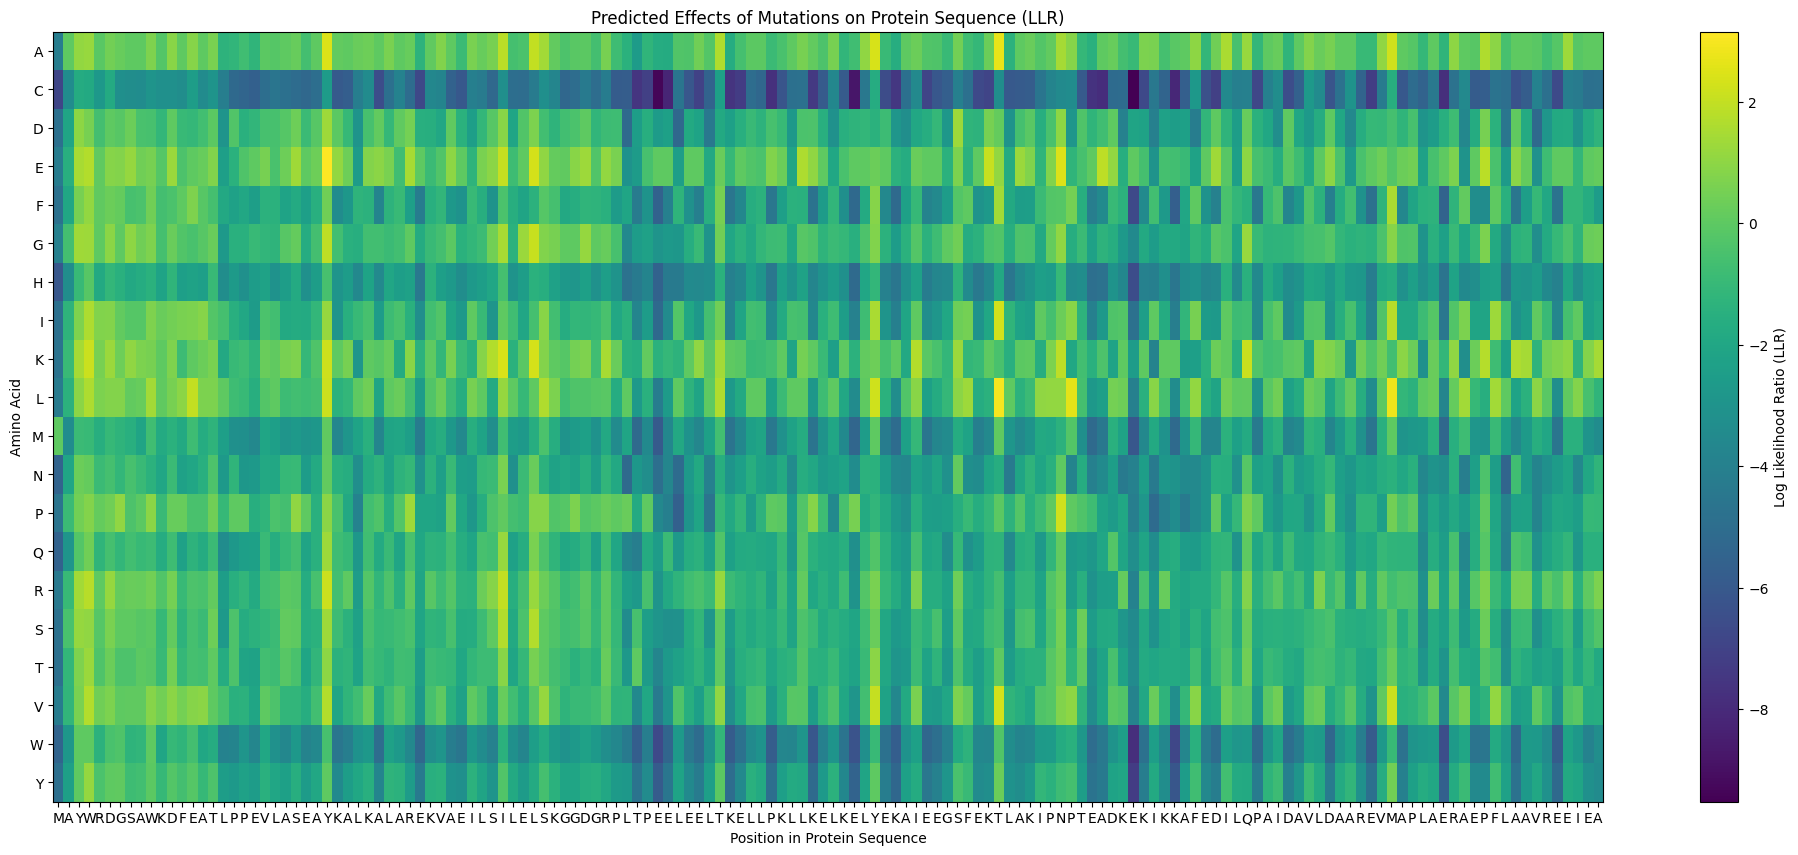

Average LLR score of the model for the best mutation sequence: -1.61

Sequence with Best Mutations:
Sequence: MAYWRDGSAWKDFEATLPPEVLASEAYKALKALAREKVAEILSILELSKGGDGRPLTPEELEELTKELLPKLLKELKELYEKAIEEGSFEKTLAKIPNPTEADKEKIKKAFEDILQPAIDAVLDAAREVMAPLAERAEPFLAAVREEIEA
Score: 0.9408234903085851


In [12]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from transformers import AutoTokenizer, EsmForMaskedLM
from sklearn.preprocessing import LabelEncoder

# Load the model and tokenizer
model_name = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = EsmForMaskedLM.from_pretrained(model_name)

# Assuming sequence_with_best_mutations is defined earlier
protein_sequence = sequence_with_best_mutations  # Redefine protein sequence here

# Tokenize the input sequence
input_ids = tokenizer.encode(protein_sequence, return_tensors="pt")
sequence_length = input_ids.shape[1] - 2  # Excluding the special tokens

# List of amino acids
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

# Initialize heatmap
heatmap = np.zeros((20, sequence_length))

# Calculate LLRs for each position and amino acid
for position in range(1, sequence_length + 1):
    # Mask the target position
    masked_input_ids = input_ids.clone()
    masked_input_ids[0, position] = tokenizer.mask_token_id

    # Get logits for the masked token
    with torch.no_grad():
        logits = model(masked_input_ids).logits

    # Calculate log probabilities
    probabilities = torch.nn.functional.softmax(logits[0, position], dim=0)
    log_probabilities = torch.log(probabilities)

    # Get the log probability of the wild-type residue
    wt_residue = input_ids[0, position].item()
    log_prob_wt = log_probabilities[wt_residue].item()

    # Calculate LLR for each variant
    for i, amino_acid in enumerate(amino_acids):
        log_prob_mt = log_probabilities[tokenizer.convert_tokens_to_ids(amino_acid)].item()
        heatmap[i, position - 1] = log_prob_mt - log_prob_wt

# Calculate the average LLR score
average_llr = np.mean(heatmap)

# Prepare data for JSON output
output_data = {
    "protein_sequence": protein_sequence,
    "heatmap": heatmap.tolist(),  # Convert numpy array to list for JSON serialization
    "average_llr_score": average_llr
}

# Save data to a JSON file
json_output_file = "protein_analysis_improved_mutations.json"
with open(json_output_file, "w") as f:
    json.dump(output_data, f, indent=4)

# Visualize the heatmap
plt.figure(figsize=(25, 10))
plt.imshow(heatmap, cmap="viridis", aspect="auto")
plt.xticks(range(sequence_length), list(protein_sequence))
plt.yticks(range(20), amino_acids)
plt.xlabel("Position in Protein Sequence")
plt.ylabel("Amino Acid")
plt.title("Predicted Effects of Mutations on Protein Sequence (LLR)")
plt.colorbar(label="Log Likelihood Ratio (LLR)")
plt.show()

# Print the average LLR score
print(f"Average LLR score of the model for the best mutation sequence: {average_llr:.2f}")

# Prepare inputs for the MPNN model
label_encoder = LabelEncoder()
label_encoder.fit(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])

# Encode the amino acids to integer indices
encoded_sequence = label_encoder.transform(list(protein_sequence))

# Convert the encoded sequence to a JAX-compatible array (2D array)
protein_sequence_array = jnp.array([encoded_sequence])  # Shape (1, N)

# Use sequence_with_best_mutations for scoring
out = mpnn_model.sample(
    num=1,  # Since we're just scoring one sequence
    batch=1,
    temperature=mpnn_sampling_temp,
    seqs=protein_sequence_array  # Pass the exact sequence here
)

# Retrieve and print the score
score = out["score"][0]  # Retrieve score from output

# Add score to output data
output_data["mpnn_score"] = score

# Save updated data to JSON
with open(json_output_file, "w") as f:
    json.dump(output_data, f, indent=4)


# Output the result
print("\nSequence with Best Mutations:")
print(f"Sequence: {output_data['protein_sequence']}")
print(f"Score: {output_data['mpnn_score']}")


# Heatmap for the sequence with negative mutations

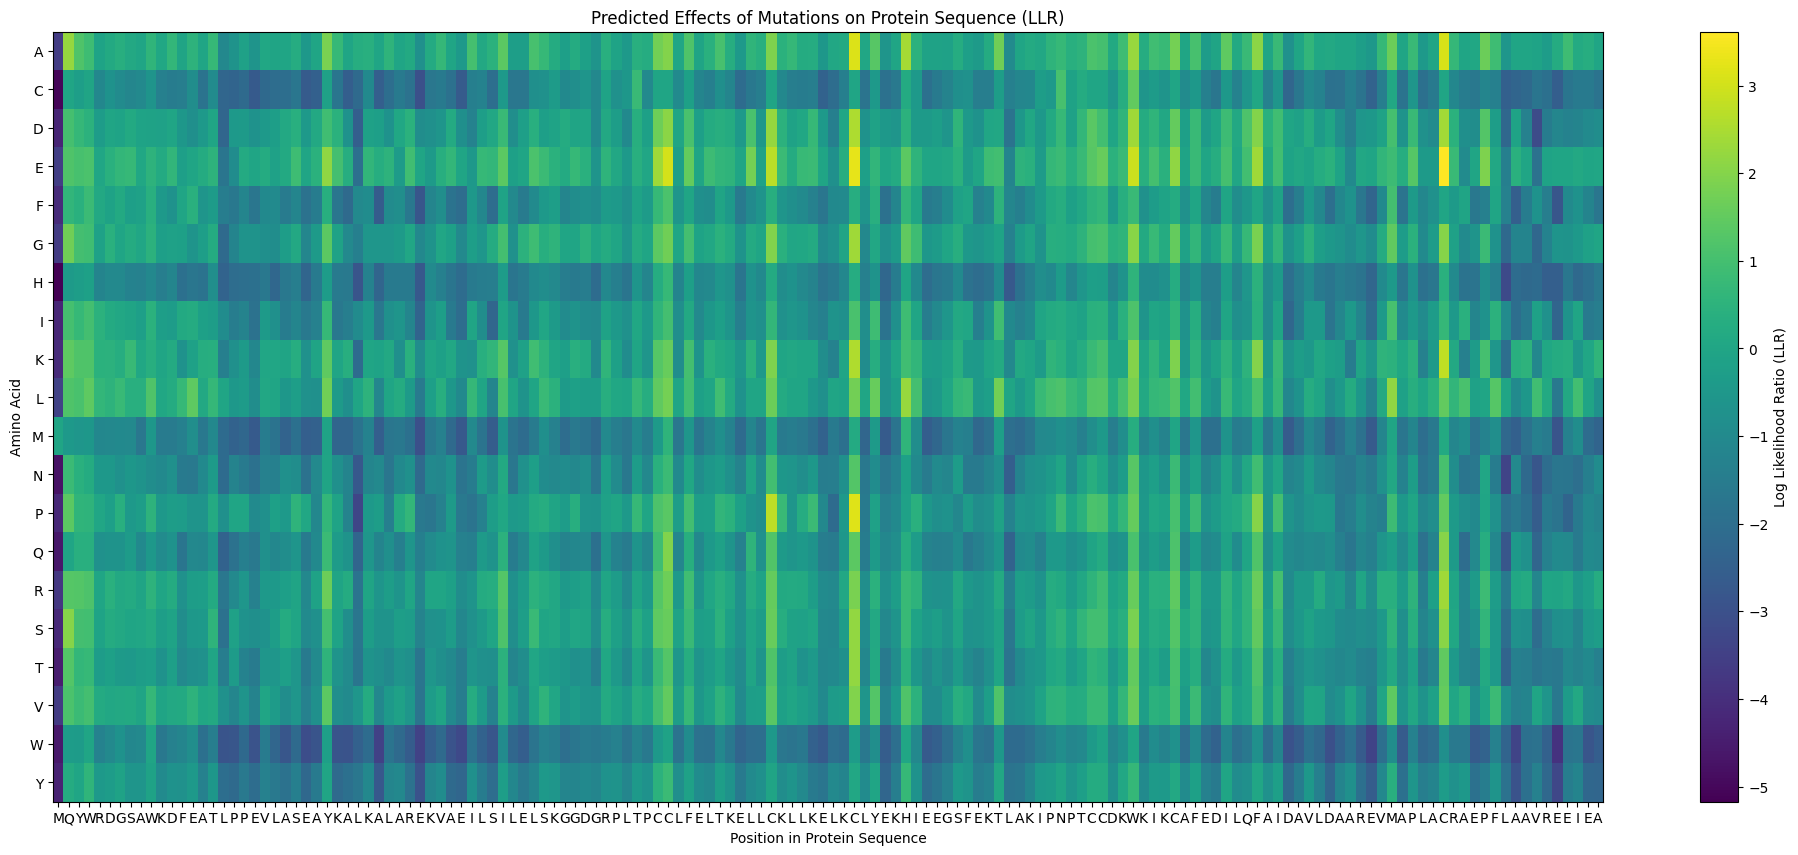

Average LLR score of the model for the worst mutation sequence: -0.51

Sequence with Worst Mutations:
Sequence: MQYWRDGSAWKDFEATLPPEVLASEAYKALKALAREKVAEILSILELSKGGDGRPLTPCCLFELTKELLCKLLKELKCLYEKHIEEGSFEKTLAKIPNPTCCDKWKIKCAFEDILQFAIDAVLDAAREVMAPLACRAEPFLAAVREEIEA
Score: 0.9473586947087683


In [13]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from transformers import AutoTokenizer, EsmForMaskedLM
from sklearn.preprocessing import LabelEncoder

# Load the model and tokenizer
model_name = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = EsmForMaskedLM.from_pretrained(model_name)

# Assuming sequence_with_worst_mutations is defined earlier
protein_sequence = sequence_with_worst_mutations  # Redefine protein sequence here

# Tokenize the input sequence
input_ids = tokenizer.encode(protein_sequence, return_tensors="pt")
sequence_length = input_ids.shape[1] - 2  # Excluding the special tokens

# List of amino acids
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

# Initialize heatmap
heatmap = np.zeros((20, sequence_length))

# Calculate LLRs for each position and amino acid
for position in range(1, sequence_length + 1):
    # Mask the target position
    masked_input_ids = input_ids.clone()
    masked_input_ids[0, position] = tokenizer.mask_token_id

    # Get logits for the masked token
    with torch.no_grad():
        logits = model(masked_input_ids).logits

    # Calculate log probabilities
    probabilities = torch.nn.functional.softmax(logits[0, position], dim=0)
    log_probabilities = torch.log(probabilities)

    # Get the log probability of the wild-type residue
    wt_residue = input_ids[0, position].item()
    log_prob_wt = log_probabilities[wt_residue].item()

    # Calculate LLR for each variant
    for i, amino_acid in enumerate(amino_acids):
        log_prob_mt = log_probabilities[tokenizer.convert_tokens_to_ids(amino_acid)].item()
        heatmap[i, position - 1] = log_prob_mt - log_prob_wt

# Calculate the average LLR score
average_llr = np.mean(heatmap)

# Prepare data for JSON output
output_data = {
    "protein_sequence": protein_sequence,
    "heatmap": heatmap.tolist(),  # Convert numpy array to list for JSON serialization
    "average_llr_score": average_llr
}

# Save data to a JSON file
json_output_file = "protein_analysis_worst_mutations.json"
with open(json_output_file, "w") as f:
    json.dump(output_data, f, indent=4)

# Visualize the heatmap
plt.figure(figsize=(25, 10))
plt.imshow(heatmap, cmap="viridis", aspect="auto")
plt.xticks(range(sequence_length), list(protein_sequence))
plt.yticks(range(20), amino_acids)
plt.xlabel("Position in Protein Sequence")
plt.ylabel("Amino Acid")
plt.title("Predicted Effects of Mutations on Protein Sequence (LLR)")
plt.colorbar(label="Log Likelihood Ratio (LLR)")
plt.show()

# Print the average LLR score
print(f"Average LLR score of the model for the worst mutation sequence: {average_llr:.2f}")

# Prepare inputs for the MPNN model
label_encoder = LabelEncoder()
label_encoder.fit(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])

# Encode the amino acids to integer indices
encoded_sequence = label_encoder.transform(list(protein_sequence))

# Convert the encoded sequence to a JAX-compatible array (2D array)
protein_sequence_array = jnp.array([encoded_sequence])  # Shape (1, N)

# Use sequence_with_worst_mutations for scoring
out = mpnn_model.sample(
    num=1,  # Since we're just scoring one sequence
    batch=1,
    temperature=mpnn_sampling_temp,
    seqs=protein_sequence_array  # Pass the exact sequence here
)

# Retrieve and print the score
score = out["score"][0]  # Retrieve score from output

# Add score to output data
output_data["mpnn_score"] = score

# Save updated data to JSON
with open(json_output_file, "w") as f:
    json.dump(output_data, f, indent=4)


# Output the result
print("\nSequence with Worst Mutations:")
print(f"Sequence: {output_data['protein_sequence']}")
print(f"Score: {output_data['mpnn_score']}")


# Alanine control


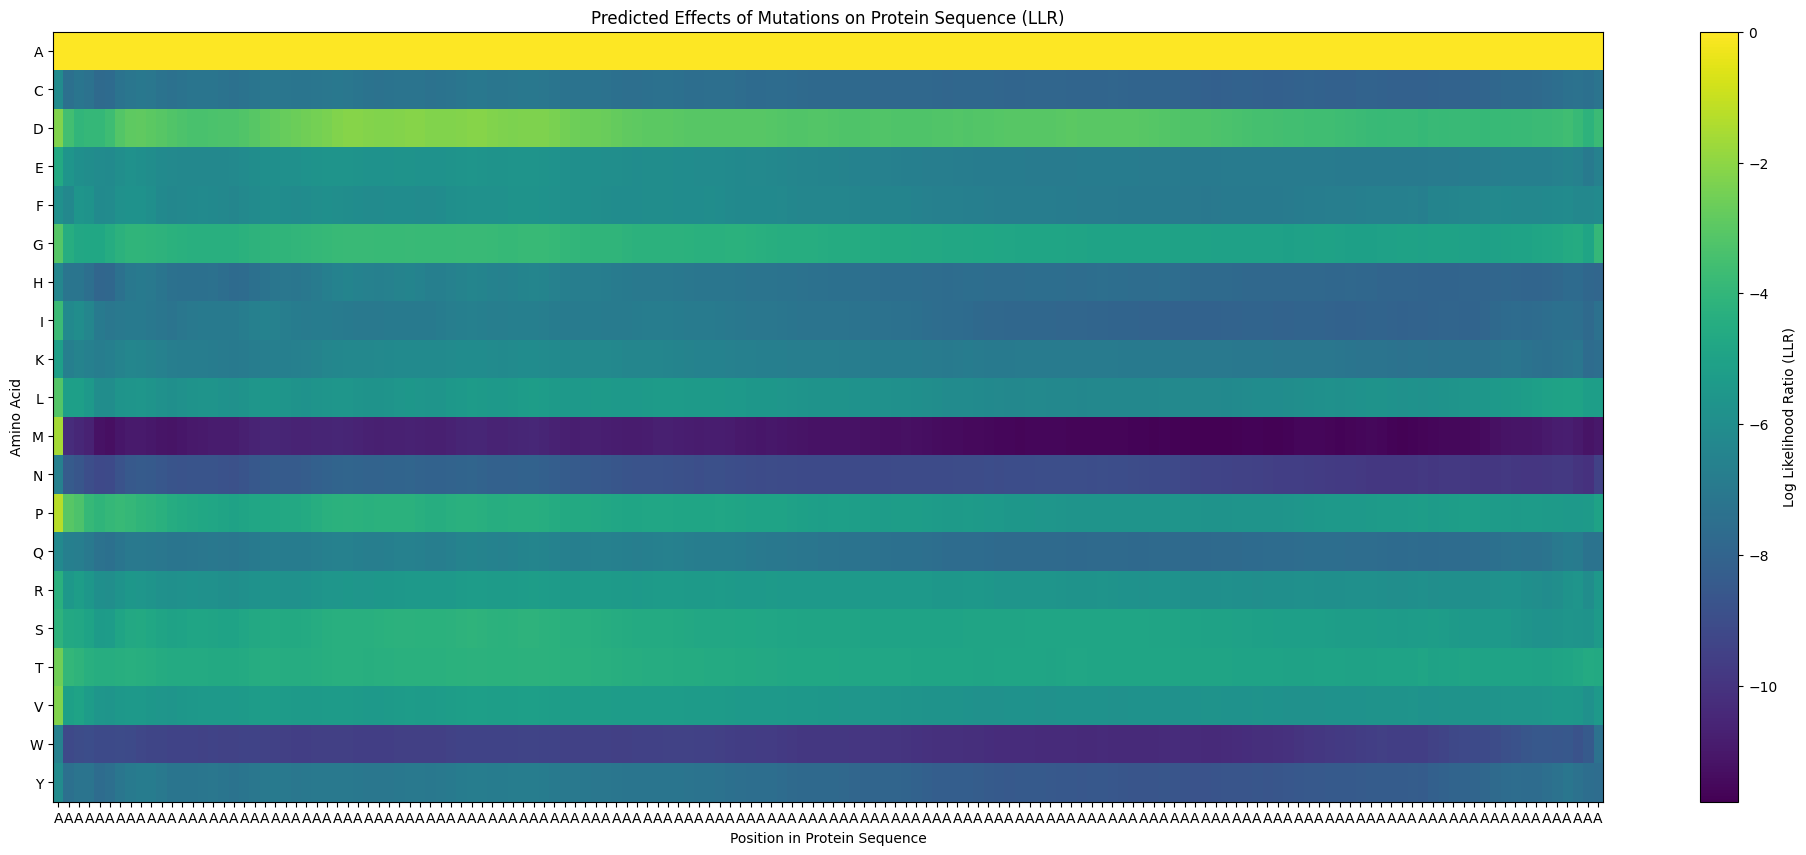

Average LLR score of the model for the sequence of 'A' repeated 150 times: -6.25
Sequence of 'A' repeated 150 times:
Sequence: AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
Score: 0.9096689011543523


In [14]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from transformers import AutoTokenizer, EsmForMaskedLM
from sklearn.preprocessing import LabelEncoder

# Load the model and tokenizer
model_name = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = EsmForMaskedLM.from_pretrained(model_name)


protein_sequence = 'A' * LENGTH  # Protein sequence of 'A' repeated for LENGTH

# Tokenize the input sequence
input_ids = tokenizer.encode(protein_sequence, return_tensors="pt")
sequence_length = input_ids.shape[1] - 2  # Excluding the special tokens

# List of amino acids
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

# Initialize heatmap
heatmap = np.zeros((20, sequence_length))

# Calculate LLRs for each position and amino acid
for position in range(1, sequence_length + 1):
    # Mask the target position
    masked_input_ids = input_ids.clone()
    masked_input_ids[0, position] = tokenizer.mask_token_id

    # Get logits for the masked token
    with torch.no_grad():
        logits = model(masked_input_ids).logits

    # Calculate log probabilities
    probabilities = torch.nn.functional.softmax(logits[0, position], dim=0)
    log_probabilities = torch.log(probabilities)

    # Get the log probability of the wild-type residue
    wt_residue = input_ids[0, position].item()
    log_prob_wt = log_probabilities[wt_residue].item()

    # Calculate LLR for each variant
    for i, amino_acid in enumerate(amino_acids):
        log_prob_mt = log_probabilities[tokenizer.convert_tokens_to_ids(amino_acid)].item()
        heatmap[i, position - 1] = log_prob_mt - log_prob_wt

# Calculate the average LLR score
average_llr = np.mean(heatmap)

# Prepare data for JSON output
output_data = {
    "protein_sequence": protein_sequence,
    "heatmap": heatmap.tolist(),  # Convert numpy array to list for JSON serialization
    "average_llr_score": average_llr
}

# Save data to a JSON file
json_output_file = "protein_analysis_A_sequence.json"
with open(json_output_file, "w") as f:
    json.dump(output_data, f, indent=4)

# Visualize the heatmap
plt.figure(figsize=(25, 10))
plt.imshow(heatmap, cmap="viridis", aspect="auto")
plt.xticks(range(sequence_length), list(protein_sequence))
plt.yticks(range(20), amino_acids)
plt.xlabel("Position in Protein Sequence")
plt.ylabel("Amino Acid")
plt.title("Predicted Effects of Mutations on Protein Sequence (LLR)")
plt.colorbar(label="Log Likelihood Ratio (LLR)")
plt.show()

# Print the average LLR score
print(f"Average LLR score of the model for the sequence of 'A' repeated {LENGTH} times: {average_llr:.2f}")

# Prepare inputs for the MPNN model
label_encoder = LabelEncoder()
label_encoder.fit(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])

# Encode the amino acids to integer indices
encoded_sequence = label_encoder.transform(list(protein_sequence))

# Convert the encoded sequence to a JAX-compatible array (2D array)
protein_sequence_array = jnp.array([encoded_sequence])  # Shape (1, N)

# Use protein_sequence for scoring
out = mpnn_model.sample(
    num=1,  # Since we're just scoring one sequence
    batch=1,
    temperature=mpnn_sampling_temp,
    seqs=protein_sequence_array  # Pass the exact sequence here
)

# Retrieve and print the score
score = out["score"][0]  # Retrieve score from output

# Add score to output data
output_data["mpnn_score"] = score

# Save updated data to JSON
with open(json_output_file, "w") as f:
    json.dump(output_data, f, indent=4)

# Output the result
print(f"Sequence of 'A' repeated {LENGTH} times:")
print(f"Sequence: {output_data['protein_sequence']}")
print(f"Score: {output_data['mpnn_score']}")


# Now try looping improvement cycle to create best sequence

Best Mutation:
Amino Acid: F, Position: 26, LLR: -0.3799
Average LLR score of the model for the best mutation sequence: -1.24

Sequence with Best Mutations:
Score: 0.9542252950727572
Best protein sequence: MQYWRDGSAWKDFEATLPPEVLASEFYKALKALAREKVAEILSILELSKGGDGRPLTPEELFELTKELLPKLLKELKELYEKHIEEGSFEKTLAKIPNPTEADKEKIKKAFEDILQFAIDAVLDAAREVMAPLAERAEPFLAAVREEIEA
Best Mutation:
Amino Acid: C, Position: 105, LLR: -8.7031
Average LLR score of the model for the best mutation sequence: -1.03

Sequence with Best Mutations:
Score: 0.9241018278777445
Best protein sequence: MQYWRDGSAWKDFEATLPPEVLASEFYKALKALAREKVAEILSILELSKGGDGRPLTPEELFELTKELLPKLLKELKELYEKHIEEGSFEKTLAKIPNPTEADKCKIKKAFEDILQFAIDAVLDAAREVMAPLAERAEPFLAAVREEIEA
Best Mutation:
Amino Acid: C, Position: 59, LLR: -6.5432
Average LLR score of the model for the best mutation sequence: -0.89

Sequence with Best Mutations:
Score: 0.9553458583711463
Best protein sequence: MQYWRDGSAWKDFEATLPPEVLASEFYKALKALAREKVAEILSILELSKGGDGRPLTPCELFELTKELLPKLLKELKEL

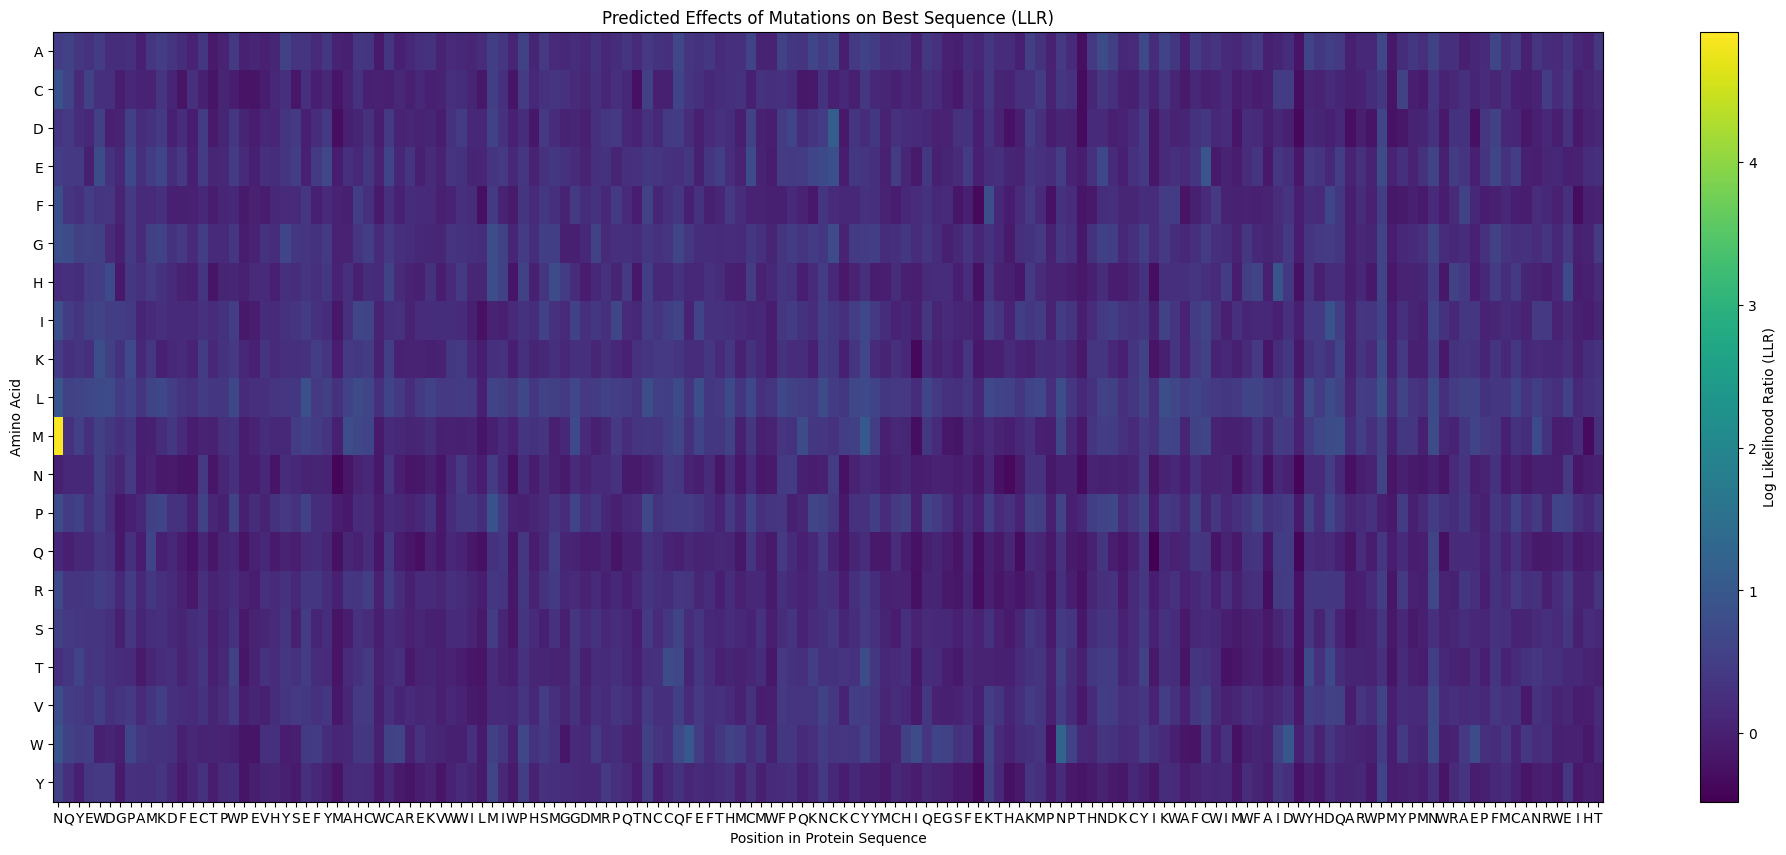

Initial protein sequence MQYWRDGSAWKDFEATLPPEVLASEAYKALKALAREKVAEILSILELSKGGDGRPLTPEELFELTKELLPKLLKELKELYEKHIEEGSFEKTLAKIPNPTEADKEKIKKAFEDILQFAIDAVLDAAREVMAPLAERAEPFLAAVREEIEA
Best protein sequence: NQYEWDGPAMKDFECTPWPEVHYSEFYMAHCWCAREKVWWILMIWPHSMGGDMRPQTNCCQFEFTHMCMWFPQKNCKCYYMCHIQEGSFEKTHAKMPNPTHNDKCYIKWAFCWIMWFAIDWYHDQARWPMYPMNWRAEPFMCANRWEIHT
Initial average LLR score of the model for the mutation sequence: 0.24
Final average LLR score of the model for the best mutation sequence: 0.21


In [20]:
# Initialize variables
best_heatmap = heatmap_initial  # Start with the initial heatmap
initial_average_llr = np.mean(heatmap_initial)  # Calculate initial average LLR
best_protein_sequence = protein_sequence_initial

# Loop over the mutations
for index in range(int(LENGTH / 2)):
    # Flatten the heatmap and sort indices to get the mutation with the lowest LLR
    flat_heatmap = best_heatmap.flatten()
    sorted_indices = np.argsort(flat_heatmap)  # Ascending order

    # Get the mutation with the lowest LLR (top 1 most wild-type aligned)
    best_indices = sorted_indices[0:1]  # Top 1 index with the lowest LLR

    # Convert flat indices back to amino acid and position
    best_mutations = [(amino_acids[idx // sequence_length], idx % sequence_length + 1, flat_heatmap[idx]) for idx in best_indices]

    # Print the best mutations
    print("Best Mutation:")
    for aa, pos, score in best_mutations:
        print(f"Amino Acid: {aa}, Position: {pos}, LLR: {score:.4f}")

    # Apply the best mutations (those with the lowest LLR)
    best_protein_sequence = apply_mutations(best_protein_sequence, best_mutations)

    # Load model and tokenizer for sequence analysis
    model_name = "facebook/esm2_t6_8M_UR50D"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = EsmForMaskedLM.from_pretrained(model_name)

    # Tokenize the new best protein sequence
    input_ids = tokenizer.encode(best_protein_sequence, return_tensors="pt")
    sequence_length = input_ids.shape[1] - 2  # Excluding the special tokens

    # Calculate LLRs for each position and amino acid
    for position in range(1, sequence_length + 1):
        # Mask the target position
        masked_input_ids = input_ids.clone()
        masked_input_ids[0, position] = tokenizer.mask_token_id

        # Get logits for the masked token
        with torch.no_grad():
            logits = model(masked_input_ids).logits

        # Calculate log probabilities
        probabilities = torch.nn.functional.softmax(logits[0, position], dim=0)
        log_probabilities = torch.log(probabilities)

        # Get the log probability of the wild-type residue
        wt_residue = input_ids[0, position].item()
        log_prob_wt = log_probabilities[wt_residue].item()

        # Calculate LLR for each variant and update the heatmap
        for i, amino_acid in enumerate(amino_acids):
            log_prob_mt = log_probabilities[tokenizer.convert_tokens_to_ids(amino_acid)].item()
            best_heatmap[i, position - 1] = log_prob_mt - log_prob_wt  # Update heatmap with mutation effect

    # Calculate the average LLR score for the best mutation sequence
    average_llr = np.mean(best_heatmap)
    print(f"Average LLR score of the model for the best mutation sequence: {average_llr:.2f}")

    # Prepare inputs for the MPNN model
    label_encoder = LabelEncoder()
    label_encoder.fit(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])

    # Encode the amino acids to integer indices
    encoded_sequence = label_encoder.transform(list(best_protein_sequence))

    # Convert the encoded sequence to a JAX-compatible array (2D array)
    protein_sequence_array = jnp.array([encoded_sequence])  # Shape (1, N)

    # Use sequence_with_best_mutations for scoring
    out = mpnn_model.sample(
        num=1,  # Since we're just scoring one sequence
        batch=1,
        temperature=mpnn_sampling_temp,
        seqs=protein_sequence_array  # Pass the exact sequence here
    )

    # Retrieve and print the score
    score = out["score"][0]  # Retrieve score from output

    # Add score to output data
    output_data["mpnn_score"] = score

    # Output the result
    print("\nSequence with Best Mutations:")
    print(f"Score: {output_data['mpnn_score']}")
    print(f'Best protein sequence: {best_protein_sequence}')
'''
# Ensure that the first amino acid in the sequence is Methionine (M)
if best_protein_sequence[0] != 'M':
    best_protein_sequence = 'M' + best_protein_sequence[1:]

# Print the updated sequence with Methionine at the first position
print(f"Final protein sequence with Methionine at the first position: {best_protein_sequence}")
'''

# Visualize the heatmap
plt.figure(figsize=(25, 10))
plt.imshow(best_heatmap, cmap="viridis", aspect="auto")
plt.xticks(range(sequence_length), list(best_protein_sequence))
plt.yticks(range(20), amino_acids)
plt.xlabel("Position in Protein Sequence")
plt.ylabel("Amino Acid")
plt.title("Predicted Effects of Mutations on Best Sequence (LLR)")
plt.colorbar(label="Log Likelihood Ratio (LLR)")
plt.show()

# Final print statements
print(f'Initial protein sequence {protein_sequence_initial}')
print(f'Best protein sequence: {best_protein_sequence}')
print(f"Initial average LLR score of the model for the mutation sequence: {initial_average_llr:.2f}")
print(f"Final average LLR score of the model for the best mutation sequence: {average_llr:.2f}")
